*SOURCES*
- Pytorch Documentation
- Deepseek
- Gymnasium Documentation

# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
#Standard imports
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

env.reset()
#env_render.reset()

(array([ 0.01126101,  0.01669457, -0.02000524,  0.03537978], dtype=float32),
 {})

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [3]:
def compute_returns(rewards: List[float], gamma: float) -> List[float]:
    """Compute discounted returns for each step in an episode."""
    returns = []
    running_return = 0
    for r in reversed(rewards):
        running_return = r + gamma * running_return
        returns.insert(0, running_return)
    return returns

def run_episode(env: gym.Env, 
               policy: torch.nn.Module,
               max_steps: int = 1000) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[float]]:
    """Run a single episode using the current policy."""
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    obs, _ = env.reset()
    done = False
    steps = 0
    
    while not done and steps < max_steps:
        # Convert numpy array to tensor
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        # Get action distribution from policy
        action_dist = policy(obs_tensor)
        
        # Sample action
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        
        # Take action in environment
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        # Store transition
        observations.append(obs_tensor)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        
        obs = next_obs
        steps += 1
    
    # Convert lists to tensors
    observations = torch.cat(observations).to(device)
    actions = torch.cat(actions).to(device)
    log_probs = torch.cat(log_probs).to(device)
    
    return observations, actions, log_probs, rewards

In [ ]:
class REINFORCE:
    """REINFORCE policy gradient algorithm with proper evaluation metrics."""
    
    def __init__(self,                  
                 policy: torch.nn.Module,
                 gamma: float = 0.99,
                 learning_rate: float = 1e-2
                 ):
        self.policy = policy
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)  
        self.gamma = gamma
        self.training_metrics = {
            'eval_rewards': [],
            'eval_lengths': [],
            'timesteps': []
        }
    
    def evaluate_policy(self, 
                       env: gym.Env, 
                       num_episodes: int = 10) -> Tuple[float, float]:
        """
        Evaluate policy by running multiple episodes.
        
        Args:
            env: Environment to evaluate in
            num_episodes: Number of evaluation episodes
            
        Returns:
            Tuple of (average total reward, average episode length)
        """
        total_rewards = []
        episode_lengths = []
        
        self.policy.eval()
        with torch.no_grad():
            for _ in range(num_episodes): # iterate over input times episodes
                obs, _ = env.reset()
                done = False
                total_reward = 0
                steps = 0
                
                while not done:
                    obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                    action = self.policy(obs_tensor).sample().item() #take an action
                    obs, reward, terminated, truncated, _ = env.step(action) # step in the environment
                    done = terminated or truncated
                    total_reward += reward # accumulate reward
                    steps += 1
                
                total_rewards.append(total_reward)
                episode_lengths.append(steps)

        avg_reward = np.mean(total_rewards)
        avg_length = np.mean(episode_lengths)
        return avg_reward, avg_length
    
    def train(self, 
             env: gym.Env,
             num_episodes: int = 1000,
             eval_every: int = 100,
             eval_episodes: int = 10,
             render_every: Optional[int] = None,
             early: bool = True) -> Dict[str, List]:
        """
        Train the policy with periodic evaluation.
        
        Args:
            env: Training environment
            num_episodes: Total training episodes
            eval_every: Evaluate every N episodes
            eval_episodes: Number of episodes for evaluation (M)
            render_every: Optional render frequency
            
        Returns:
            Dictionary containing training metrics:
            - eval_rewards: List of evaluation average rewards
            - eval_lengths: List of evaluation average lengths
            - timesteps: List of evaluation timesteps
        """
        self.policy.train()
        timestep = 0
        best_reward = 0
        avg_length = 0
        avg_reward = 0
        count_early = 0
        
        for episode in range(1, num_episodes + 1):
            # Run training episode
            observations, actions, log_probs, rewards = run_episode(env, self.policy)
            timestep += len(rewards)
            
            # Update policy
            returns = torch.tensor(compute_returns(rewards, self.gamma), dtype=torch.float32).to(device)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            loss = (-log_probs * returns).mean()

            # Decay every 50 episodes after episode 200
            if episode > 200 and episode % 50 == 0 and avg_reward >= 200:
                for g in self.optimizer.param_groups:
                    g['lr'] *= 0.9  # Gentle decay after episode 200
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Periodic evaluation every N episodes
            if episode % eval_every == 0:
                avg_reward, avg_length = self.evaluate_policy(env, eval_episodes) # M = eval_episodes
                self.training_metrics['eval_rewards'].append(avg_reward)
                self.training_metrics['eval_lengths'].append(avg_length)
                self.training_metrics['timesteps'].append(timestep)
                
                print(f"Episode {episode} | "
                      f"Avg Reward: {avg_reward:.1f} | "
                      f"Avg Length: {avg_length:.1f} | "
                      f"Timesteps: {timestep}")

                # Early stopping
                if avg_reward >= 485 and early == True:
                    count_early += 1
                    print(f"The top was reached {count_early} times in a row")
                    if count_early >= 5:  # Require 5 consecutive good evaluations
                        print(f"Consistent solution achieved at episode {episode}")
                        break
                else:
                    count_early = 0  # Reset counter if performance drops
            
            # Optional rendering
            if render_every and episode % render_every == 0:
                self.policy.eval()
                run_episode(gym.make('CartPole-v1', render_mode='human'), self.policy)
                self.policy.train()
        
        return self.training_metrics

In [5]:
class PolicyNet(nn.Module):
    """Policy network for CartPole that returns action distributions."""
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)  # Output logits, don't apply softmax here
        return torch.distributions.Categorical(logits=s)  # Let PyTorch handle softmax in Categorical

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

Episode 50 | Avg Reward: 21.9 | Avg Length: 21.9 | Timesteps: 986
Episode 100 | Avg Reward: 59.1 | Avg Length: 59.1 | Timesteps: 3011
Episode 150 | Avg Reward: 205.2 | Avg Length: 205.2 | Timesteps: 9248
Episode 200 | Avg Reward: 456.8 | Avg Length: 456.8 | Timesteps: 25010
Episode 250 | Avg Reward: 125.4 | Avg Length: 125.4 | Timesteps: 39089
Episode 300 | Avg Reward: 337.9 | Avg Length: 337.9 | Timesteps: 48911
Episode 350 | Avg Reward: 472.1 | Avg Length: 472.1 | Timesteps: 68049
Episode 400 | Avg Reward: 483.6 | Avg Length: 483.6 | Timesteps: 91580
Episode 450 | Avg Reward: 483.9 | Avg Length: 483.9 | Timesteps: 116280
Episode 500 | Avg Reward: 498.8 | Avg Length: 498.8 | Timesteps: 141188
The top was reached 1 times in a row
Episode 550 | Avg Reward: 497.6 | Avg Length: 497.6 | Timesteps: 165893
The top was reached 2 times in a row
Episode 600 | Avg Reward: 466.4 | Avg Length: 466.4 | Timesteps: 187777
Episode 650 | Avg Reward: 497.0 | Avg Length: 497.0 | Timesteps: 212455
The top

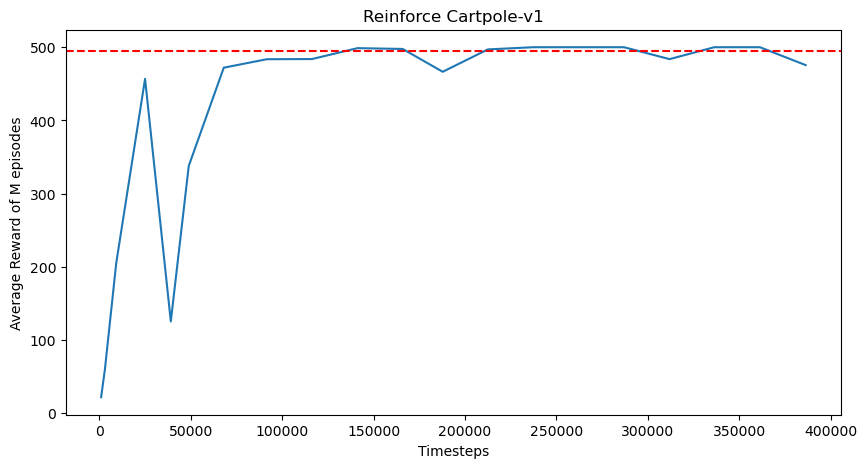

In [ ]:
device = torch.device("cpu")
# con gpu 13m 20s
# con cpu 5m 41s

if __name__ == "__main__":

    M = 20 # Number of evaluation episodes run during each evaluation phase (M)
    N = 50 # Policy evalution every 50 episodes (N)

    seed = 2112
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    
    policy = PolicyNet(env).to(device)  # Using the PolicyNet from previous implementation
    
    agent = REINFORCE(policy, 
                    gamma=0.99,
                    learning_rate=5e-3,
                    )  # Reduced from 1e-2
    
    # Train with evaluation every 50 episodes using 20 evaluation episodes
    metrics = agent.train(
        env, 
        num_episodes=1000, 
        eval_every=N, 
        eval_episodes=M,
        #render_every=100,  # Optional rendering
        early = True
    )

    policy.eval()
    test_rewards = []
    for _ in range(100):
        _, _, _, rewards = run_episode(env, policy)
        test_rewards.append(sum(rewards))
    print(f"True average performance: {np.mean(test_rewards):.1f} ± {np.std(test_rewards):.1f}")
    
    # Plotting the results
    plt.figure(figsize=(10,5))
    plt.plot(metrics['timesteps'], metrics['eval_rewards'])
    plt.axhline(495, c='r', linestyle='--', label='Target')
    plt.xlabel('Timesteps')
    plt.ylabel(f'Average Reward of M episodes')
    plt.title('Reinforce Cartpole-v1')
    plt.show()

**How CartPole Scoring Works:**
- +1 reward for every step pole stays upright
- Maximum episode length: 500 steps (hence max reward = 500)
- Termination when:
    + Pole angle > 12°
    + Cart moves > 2.4 units from center
    + 500 steps reached

**Analisi:**

L'algoritmo **REINFORCE** mostra un chiaro apprendimento progressivo nel tempo. Nelle prime 100–200 iterazioni, il reward medio cresce rapidamente, da circa 22 a oltre 450, segnalando una buona fase di esplorazione e apprendimento iniziale. Dopo un calo temporaneo attorno all’episodio 250, il training riprende efficacemente, raggiungendo valori prossimi al massimo (500) entro l’episodio 400. Tra gli episodi 700 e 800 si osserva una stabilizzazione con performance ottimali raggiunte in modo consecutivo (fino a 4 volte di fila, quindi non triggera early stopping). Anche se ci sono alcune oscillazioni successive, l’agente mantiene una media finale molto alta (496.7 ± 19.0). Questo indica che la policy appresa è solida e che l’algoritmo converge efficacemente su CartPole

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Same REINFORCE class as before, but with an option for a value baseline
class REINFORCEWithBaseline:
    def __init__(self, policy_net, gamma=0.99, lr_policy=1e-3,
                 use_value_baseline=False, value_net=None, lr_value=1e-3):
        self.policy = policy_net
        self.gamma = gamma
        self.use_value_baseline = use_value_baseline
        self.value_net = value_net
        self.optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=lr_policy)

        if use_value_baseline:
            self.optimizer_value = torch.optim.Adam(value_net.parameters(), lr=lr_value)

    def update(self, states, actions, rewards):
        # Compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)

        states = torch.cat(states).to(device)

        if self.use_value_baseline: # Use a value function baseline
            # Train value net and use state-dependent baseline
            values = self.value_net(states).squeeze()
            advantages = returns - values.detach()

            # Value function update
            value_loss = F.mse_loss(values, returns)
            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()
        else:
            # Use standardization baseline
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            advantages = returns  # since no value baseline

        # Policy gradient update
        log_probs = torch.cat([self.policy(s).log_prob(a) for s, a in zip(states, actions)]).to(device)

        # Fixed entropy calculation for discrete actions
        probs = torch.exp(log_probs)
        entropy = -torch.mean(probs * log_probs) 
        
        policy_loss = -(log_probs * advantages).mean() - 0.01 * entropy  # entropy regularization

        self.optimizer_policy.zero_grad()
        policy_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)  # Clip policy gradients

        self.optimizer_policy.step()


In [3]:
def run_episode(env, policy, value_net=None, max_steps=1000):
    states, actions, rewards = [], [], []
    obs, _ = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        action_dist = policy(obs_tensor)
        action = action_dist.sample()
        
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(obs_tensor)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        steps += 1

    return states, actions, rewards

def evaluate_policy_baseline(env, policy, num_episodes=10):
    """Standalone evaluation function."""
    total_rewards = []
    policy.eval()  # Set to evaluation mode
    with torch.no_grad():
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0
            while not done:
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = policy(obs_tensor).sample().item()
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
            total_rewards.append(total_reward)
    return np.mean(total_rewards)
    

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [5]:
# Your code here. Modify your implementation of REINFORCE to optionally use the standardize baseline.
class ValueNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # Outputs a scalar (value estimate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

Episode 0, Avg Reward: 32.9
Episode 50, Avg Reward: 80.0
Episode 100, Avg Reward: 116.1
Episode 150, Avg Reward: 337.8
Episode 200, Avg Reward: 380.0
Episode 250, Avg Reward: 141.3
Episode 300, Avg Reward: 500.0
Episode 350, Avg Reward: 500.0
Episode 400, Avg Reward: 495.3
Episode 450, Avg Reward: 500.0
Episode 500, Avg Reward: 310.9
Episode 550, Avg Reward: 500.0
Episode 600, Avg Reward: 500.0
Episode 650, Avg Reward: 500.0
Episode 700, Avg Reward: 500.0
Episode 750, Avg Reward: 500.0
Episode 800, Avg Reward: 500.0
Episode 850, Avg Reward: 500.0
Episode 900, Avg Reward: 500.0
Episode 950, Avg Reward: 500.0
Episode 1000, Avg Reward: 500.0


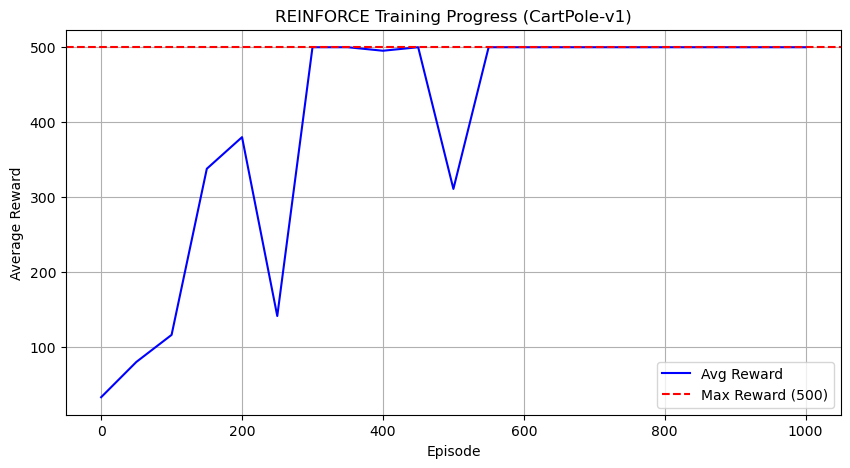

In [ ]:
## WITHOUT VALUE BASELINE - No using ValueNet ##

# 8m 39s cpu
# 14m 6s gpu
device = torch.device("cpu")
use_value_baseline = False  # False for no using value baseline, True for using it

seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('CartPole-v1')
env.reset(seed=seed)

policy_net = PolicyNet(env).to(device)
value_net = ValueNet(env.observation_space.shape[0]).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy=1e-2 #1e-3
)

# Initialize lists to store episode numbers and average rewards
episodes = []
avg_rewards = []

for episode in range(1001):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Store data for plotting
        episodes.append(episode)
        avg_rewards.append(avg_reward)

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.title("REINFORCE Training Progress (CartPole-v1)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)

# Highlight the maximum reward (500 for CartPole)
plt.axhline(y=500, color='r', linestyle='--', label='Max Reward (500)')
plt.legend()

plt.show()


**Analisi Risultati:**

L'inserimento di una **baseline standard** nel metodo REINFORCE ha portato a un apprendimento più stabile e rapido rispetto alla versione **senza baseline**. Dopo un inizio graduale, l'agente raggiunge un reward medio di 337.8 già all’episodio 150, dimostrando una rapida progressione. Nonostante un calo temporaneo attorno all’episodio 250 (141.3), il modello si riprende rapidamente, raggiungendo il reward massimo (500) già allo step 300. 

Da lì in poi, l’agente mantiene costantemente performance ottimali, con solo un peggioramento§ all’episodio 500. L’utilizzo della baseline ha chiaramente ridotto la varianza dei gradienti, favorendo la convergenza rapida e mantenendo la stabilità dell’apprendimento.


Episode 0, Avg Reward: 18.6
Episode 50, Avg Reward: 71.2
Episode 100, Avg Reward: 88.7
Episode 150, Avg Reward: 54.8
Episode 200, Avg Reward: 157.8
Episode 250, Avg Reward: 58.0
Episode 300, Avg Reward: 241.3
Episode 350, Avg Reward: 155.7
Episode 400, Avg Reward: 74.0
Episode 450, Avg Reward: 130.1
Episode 500, Avg Reward: 304.0
Episode 550, Avg Reward: 500.0
Episode 600, Avg Reward: 500.0
Episode 650, Avg Reward: 500.0
Episode 700, Avg Reward: 500.0
Episode 750, Avg Reward: 500.0
Episode 800, Avg Reward: 500.0
Episode 850, Avg Reward: 500.0
Episode 900, Avg Reward: 500.0
Episode 950, Avg Reward: 500.0
Episode 1000, Avg Reward: 500.0


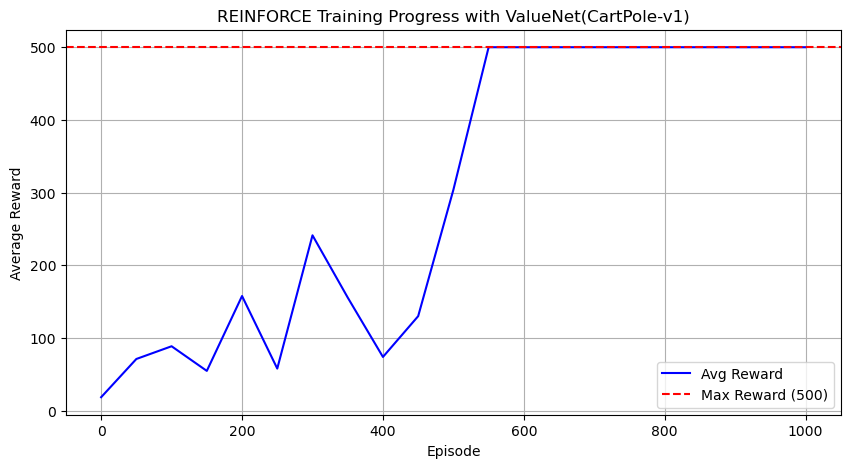

In [ ]:
## WITHOUT VALUE BASELINE - Using ValueNet ##

device = torch.device("cpu")
use_value_baseline = True  # True for using Valuenet baseline, False for no using it

seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('CartPole-v1')
env.reset(seed=seed)

policy_net = PolicyNet(env).to(device)
value_net = ValueNet(env.observation_space.shape[0]).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy=1e-2,
    lr_value=1e-3
)

# Initialize lists to store episode numbers and average rewards
episodes = []
avg_rewards = []

for episode in range(1001):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Store data for plotting
        episodes.append(episode)
        avg_rewards.append(avg_reward)

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.title("REINFORCE Training Progress with ValueNet(CartPole-v1)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)

# Highlight the maximum reward (500 for CartPole)
plt.axhline(y=500, color='r', linestyle='--', label='Max Reward (500)')
plt.legend()

plt.show()

**Analisi Risultati:**
L'utilizzo di una baseline appresa tramite **ValueNet** mostra inizialmente un apprendimento instabile, con oscillazioni tra gli episodi 50 e 400. Questo comportamento è dato dal fatto che a rete richiede tempo per adattarsi e fornire stime affidabili. 

Tuttavia, dopo l’episodio 500, l’agente raggiunge il reward massimo (500) e lo mantiene in modo stabile fino allo step 1000, dimostrando che la rete **ValueNet** ha imparato efficacemente a stimare i vantaggi. Il salto netto tra gli episodi 500 e 550 suggerisce una fase di improvviso consolidamento delle policy.Il risultato finale è ottimale e affidabile-

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from typing import Callable, Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# New Policy and Value networksfor LunarLander-v2
# LunarLander-v2 environment has an observation space continuous of 8 dimensions and an action space discrete with 4 actions

class PolicyNet(nn.Module):
    def __init__(self, state_dim=8, action_dim=4, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)        
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return torch.distributions.Categorical(logits=logits)  # Return a distribution
    
class ValueNet(nn.Module):
    def __init__(self, state_dim=8, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
import pygame
_ = pygame.init()
pygame.display.init()  # Might help PyGame not crash...

# Run the agent for a few episodes before training
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)

env_render = gym.make('LunarLander-v2', render_mode='human')
for _ in range(5):
    run_episode(env_render, policy_net)
env_render.close()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episode 0, Avg Reward: -135.2
New best model saved with average reward: -135.2
Episode 50, Avg Reward: -203.2
Episode 100, Avg Reward: -160.0
Episode 150, Avg Reward: -88.6
New best model saved with average reward: -88.6
Episode 200, Avg Reward: -193.6
Episode 250, Avg Reward: -162.2
Episode 300, Avg Reward: -98.9
Episode 350, Avg Reward: -124.1
Episode 400, Avg Reward: -124.3
Episode 450, Avg Reward: -110.6
Episode 500, Avg Reward: -75.4
New best model saved with average reward: -75.4
Episode 550, Avg Reward: -17.8
New best model saved with average reward: -17.8
Episode 600, Avg Reward: -84.5
Episode 650, Avg Reward: -18.2
Episode 700, Avg Reward: -63.0
Episode 750, Avg Reward: -42.8
Episode 800, Avg Reward: 10.3
New best model saved with average reward: 10.3
Episode 850, Avg Reward: -22.9
Episode 900, Avg Reward: -8.2
Episode 950, Avg Reward: 36.4
New best model saved with average reward: 36.4
Episode 1000, Avg Reward: 25.8
Episode 1050, Avg Reward: 72.1
New best model saved with ave

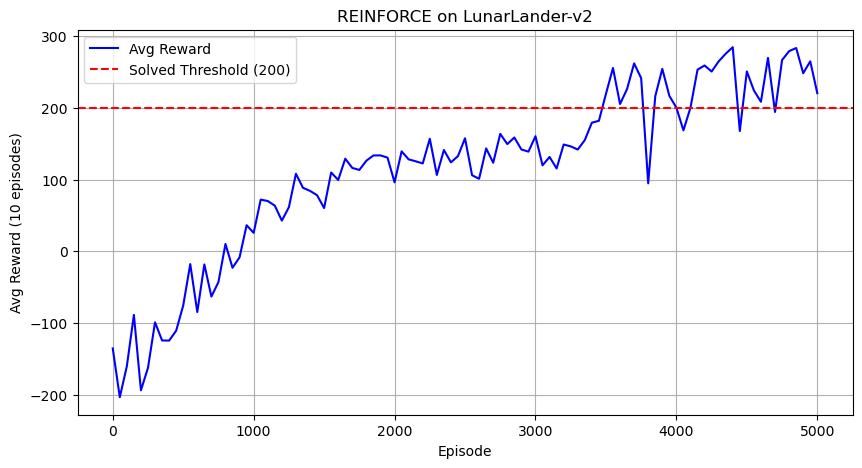

In [ ]:
## WITH VALUE BASELINE - Using ValueNet for LunarLander-v2 ##
use_value_baseline = True
env = gym.make("LunarLander-v2")
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = ValueNet(state_dim=8).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline,
    gamma=0.99,
    lr_policy= 5e-4,
    lr_value=1e-3
)

# Training
episodes = []
avg_rewards = []
best_avg_reward = float("-inf")

for episode in range(5000+1):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    # Gradual learning rate decay every 1000 episodes
    if episode % 1000 == 0:
        for param_group in agent.optimizer_policy.param_groups:
            param_group['lr'] *= 0.8 
        for param_group in agent.optimizer_value.param_groups:
            param_group['lr'] *= 0.8

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net, num_episodes=10)
        episodes.append(episode)
        avg_rewards.append(avg_reward)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Save if this is the best model so far
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'value_net_state_dict': value_net.state_dict() if value_net else None,
                'optimizer_policy_state_dict': agent.optimizer_policy.state_dict(),
                'optimizer_value_state_dict': agent.optimizer_value.state_dict() if agent.optimizer_value else None,
                'episode': episode,
                'avg_reward': avg_reward
            }, f'Lunar_best_model_valueNet.pth')
            print(f"New best model saved with average reward: {avg_reward:.1f}")
        else:
            early_counter = 0

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

**Analisi RIsultati:**
L’addestramento del modello su **LunarLander con baseline ValueNet** mostra una curva di apprendimento lenta ma costante. Le ricompense iniziali sono negative, indicando una policy ancora lontana dall’obiettivo. Tuttavia, a partire dall’episodio 500, si ha un progressivo miglioramento.

Dopo l’episodio 1500, le performance diventano più stabili e positive, suggerendo che la ValueNet ha iniziato a fornire stime utili al policy gradient. Il modello raggiunge e supera i **200 di reward medio** tra l’episodio 3500 e 5000, con picchi superiori a **280**. I salvatagi continui del miglior modello indicano un costante miglioramento. Complessivamente, la ValueNet si dimostra efficace nel lungo termine, ma richiede molte iterazioni per emergere.


<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episode 0, Avg Reward: -190.3
New best model saved with average reward: -190.3
Episode 50, Avg Reward: -192.1
Episode 100, Avg Reward: -208.4
Episode 150, Avg Reward: -148.6
New best model saved with average reward: -148.6
Episode 200, Avg Reward: -138.5
New best model saved with average reward: -138.5
Episode 250, Avg Reward: -182.7
Episode 300, Avg Reward: -146.2
Episode 350, Avg Reward: -117.4
New best model saved with average reward: -117.4
Episode 400, Avg Reward: -163.0
Episode 450, Avg Reward: -92.1
New best model saved with average reward: -92.1
Episode 500, Avg Reward: -125.2
Episode 550, Avg Reward: -126.7
Episode 600, Avg Reward: -190.6
Episode 650, Avg Reward: -90.6
New best model saved with average reward: -90.6
Episode 700, Avg Reward: -69.7
New best model saved with average reward: -69.7
Episode 750, Avg Reward: -74.0
Episode 800, Avg Reward: -47.6
New best model saved with average reward: -47.6
Episode 850, Avg Reward: -37.3
New best model saved with average reward: -37

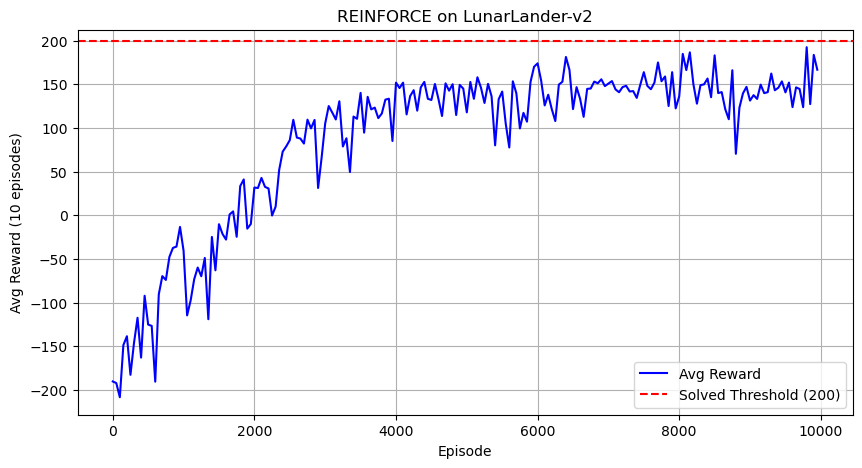

In [ ]:
## WITHOUT VALUE BASELINE - Using ValueNet for LunarLander-v2 ##

use_value_baseline = False # doesn't use ValueNet
env = gym.make("LunarLander-v2")use_value_baseline
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = ValueNet(state_dim=8).to(device) if use_value_baseline else None

agent = REINFORCEWithBaseline(
    policy_net=policy_net,
    value_net=value_net,
    use_value_baseline=use_value_baseline, 
    gamma=0.99,
    lr_policy= 3e-4,
    lr_value=1e-3
)

# Training
episodes = []
avg_rewards = []
best_avg_reward = float("-inf")

for episode in range(10000):
    states, actions, rewards = run_episode(env, policy_net)
    agent.update(states, actions, rewards)

    if episode % 50 == 0:
        avg_reward = evaluate_policy_baseline(env, policy_net, num_episodes=10)
        episodes.append(episode)
        avg_rewards.append(avg_reward)
        print(f"Episode {episode}, Avg Reward: {avg_reward:.1f}")

        # Save if this is the best model so far
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'value_net_state_dict': value_net.state_dict() if value_net else None,
                'optimizer_policy_state_dict': agent.optimizer_policy.state_dict(),
                'episode': episode,
                'avg_reward': avg_reward
            }, f'Lunar_best_model_NOvalueNet.pth')
            print(f"New best model saved with average reward: {avg_reward:.1f}")
        else:
            early_counter = 0

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

**Analisi Risultati:**

L’allenamento parte da prestazioni molto negative (intorno a -190) ma mostra un miglioramento costante già entro i **primi 1000 episodi**, con il primo valore positivo intorno all’episodio 1650. **Dai 2000 ai 4000 episodi** si osserva una forte fase di apprendimento, con l’agente che supera progressivamente soglie di performance sempre più alte (fino a +150).

**Intorno a 4000-6000 episodi**, le performance si stabilizzano con reward medi tra 130 e 150, segno che la policy appresa sta diventando consistente. **Tra 6000 e 8000** episodi, il miglior modello raggiunge un reward di 174.1.

**Dai 8000 episodi in poi** si superano anche i 180 di reward medio, con un picco di 192.6 al termine (episodio 9800), indicando una quasi convergenza. Sebbene vi siano ancora oscillazioni nei risultati medi, la tendenza complessiva è positiva e stabile con una chiara ottimizzazione del comportamento dell’agente. Complessivamente, l’agente senza ValueNet ha dimostrato un apprendimento valido ma senza raggiungere il reward di 200 che rappresenta l'obbiettivo di LunarLander, nonostante i 10000 episodi.

In [ ]:
import pygame
_ = pygame.init()
pygame.display.init()  # Might help PyGame not crash...

# Run the agent for a few episodes after training

env_render = gym.make('LunarLander-v2', render_mode='human')
for _ in range(10):
    run_episode(env_render, policy_net)
env_render.close()

In [25]:
# Load the best model and plot the results
def load_model(path, policy_net, value_net=None, agent=None):
    checkpoint = torch.load(path, weights_only=False)  # Add weights_only=False
    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    if value_net and checkpoint['value_net_state_dict']:
        value_net.load_state_dict(checkpoint['value_net_state_dict'])
    if agent:
        agent.optimizer_policy.load_state_dict(checkpoint['optimizer_policy_state_dict'])
        if agent.optimizer_value and checkpoint['optimizer_value_state_dict']:
            agent.optimizer_value.load_state_dict(checkpoint['optimizer_value_state_dict'])
    return checkpoint['episode'], checkpoint['avg_reward']

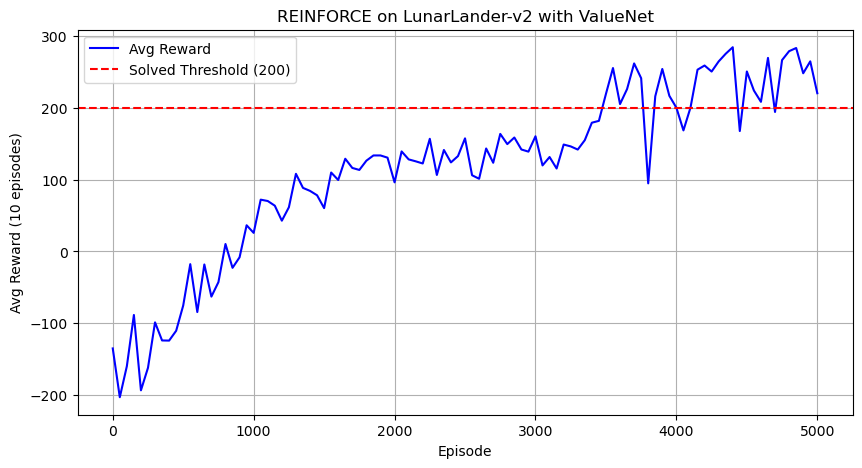

In [33]:
# To reproduce the results of using ValueNet
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = ValueNet(state_dim=8).to(device)


episodes = list(range(0, 5001, 50)) 
rewards = [
    -135.2, -203.2, -160.0, -88.6, -193.6, -162.2, -98.9, -124.1, -124.3, -110.6, 
    -75.4, -17.8, -84.5, -18.2, -63.0, -42.8, 10.3, -22.9, -8.2, 36.4, 25.8, 
    72.1, 70.2, 63.7, 42.8, 61.5, 108.1, 88.5, 84.3, 78.2, 60.3, 109.9, 99.5, 
    129.1, 116.3, 113.5, 126.4, 133.7, 133.7, 130.6, 96.2, 139.3, 128.2, 125.5, 
    122.5, 156.9, 106.5, 141.3, 124.0, 132.8, 157.5, 106.1, 101.2, 143.4, 123.5, 
    163.7, 149.5, 158.7, 142.0, 139.0, 160.4, 119.8, 131.5, 115.5, 148.9, 146.3, 
    141.9, 155.0, 179.3, 181.9, 219.4, 255.5, 205.3, 226.2, 261.9, 241.3, 94.8, 
    216.1, 254.2, 216.8, 200.2, 168.6, 200.3, 253.2, 259.0, 250.6, 264.7, 275.4, 
    284.5, 167.7, 250.7, 224.2, 208.4, 269.6, 194.3, 266.6, 279.0, 283.4, 248.2, 
    264.8, 220.4
]


last_episode, best_reward = load_model('Lunar_best_model_valueNet.pth', policy_net, value_net, _)
plt.figure(figsize=(10, 5))
plt.plot(episodes, rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2 with ValueNet")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

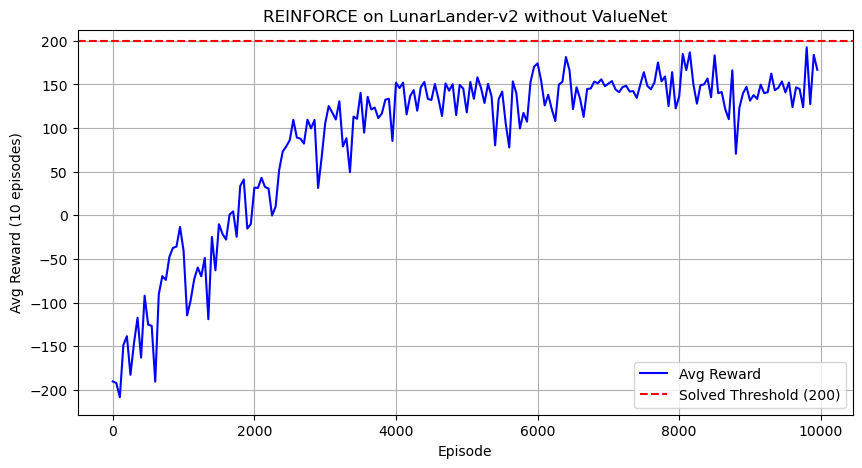

In [34]:
# To reproduce the results without using ValueNet
policy_net = PolicyNet(state_dim=8, action_dim=4).to(device)
value_net = None

episodes = list(range(0, 10000, 50))  # 0 to 9950 in steps of 50
rewards = [
    -190.3, -192.1, -208.4, -148.6, -138.5, -182.7, -146.2, -117.4, -163.0, -92.1,
    -125.2, -126.7, -190.6, -90.6, -69.7, -74.0, -47.6, -37.3, -35.8, -13.3,
    -40.5, -114.6, -97.5, -73.2, -59.8, -69.8, -48.8, -119.0, -24.8, -63.0,
    -10.2, -21.3, -27.8, 0.9, 4.5, -24.6, 33.5, 41.1, -15.2, -9.9,
    31.8, 31.3, 42.9, 32.6, 30.7, -0.2, 9.9, 51.9, 73.0, 79.0,
    86.1, 109.4, 89.1, 87.9, 82.2, 109.6, 99.6, 109.3, 31.3, 66.3,
    105.2, 125.2, 117.7, 109.8, 130.7, 78.9, 88.3, 49.5, 113.1, 110.6,
    140.3, 94.7, 135.8, 121.4, 123.4, 111.4, 116.7, 132.5, 133.6, 85.1,
    152.0, 145.8, 152.0, 115.6, 136.6, 143.4, 119.9, 146.6, 152.8, 133.5,
    132.1, 150.5, 133.2, 113.8, 151.2, 142.8, 150.2, 114.9, 149.4, 145.2,
    117.9, 152.8, 133.5, 158.1, 146.3, 128.7, 150.6, 136.3, 80.2, 133.0,
    141.8, 104.9, 77.7, 153.5, 139.8, 99.6, 117.4, 107.3, 152.9, 170.2,
    174.1, 154.4, 125.9, 138.1, 121.7, 108.0, 149.7, 153.0, 181.4, 166.6,
    121.7, 146.8, 133.5, 112.8, 144.8, 145.3, 153.2, 151.3, 155.8, 148.0,
    150.9, 153.8, 144.3, 141.0, 146.9, 148.4, 141.9, 142.3, 134.5, 149.6,
    164.0, 148.3, 144.4, 152.1, 175.1, 153.6, 159.1, 125.2, 164.0, 122.5,
    136.4, 184.9, 166.4, 186.7, 150.2, 127.9, 149.1, 150.0, 156.7, 135.3,
    183.3, 140.0, 141.2, 121.6, 110.1, 166.2, 70.5, 123.3, 139.7, 147.2,
    131.4, 137.7, 133.4, 149.7, 140.0, 141.1, 162.4, 143.3, 146.2, 153.4,
    140.8, 152.1, 124.0, 146.6, 144.7, 123.9, 192.6, 127.4, 183.8, 166.8
]


last_episode, best_reward = load_model('Lunar_best_model_NOvalueNet.pth', policy_net, None, _)
plt.figure(figsize=(10, 5))
plt.plot(episodes, rewards, 'b-', label='Avg Reward')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold (200)')
plt.title("REINFORCE on LunarLander-v2 without ValueNet")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (10 episodes)")
plt.legend()
plt.grid()
plt.show()

Purtroppo ho implementato una versione nel train che salva solamente l'ultimo modello migliore e non tiene conto della storia. Pertanto ho adottato questa scorciatoia di creazione manuale dei reward medi per riprodurrre i risultati.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 